# Adversarial Attack 

- develop a model for mnist dataset using fastai
- attack the model using foolbox (black box attack)
- check the density & coverage metrics

In [1]:
# dependencies
import os 
os.environ["GIT_PYTHON_REFRESH"] = "quiet" 
#!module load git
import foolbox as fb
import torch
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
import numpy as np

In [2]:
import torchvision
from fastai.vision.all import *

Fix the seed generator

In [3]:
torch.manual_seed(42) 
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Import the MNIST dataset and create the CNN class

In [4]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081))
])
train_set = torchvision.datasets.MNIST('./files/', train=True, download=True, transform=transforms)
test_set = torchvision.datasets.MNIST('./files/', train=False, download=True, transform=transforms)

In [5]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=True)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class CNet(nn.Module):
    def __init__(self):
        super(CNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2)
        x = F.relu(x)
        x = self.drop(self.conv2(x))
        x = F.relu(F.max_pool2d(x, 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
        

In [7]:
class NewNet(nn.Module):
    def __init__(self):
        super(NewNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(800, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.drop(F.max_pool2d(x, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 800)
        x = self.drop(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

Fastai takes the available device by default

In [8]:
data = DataLoaders(train_loader, test_loader)
learn = Learner(data, NewNet(), loss_func=F.nll_loss, opt_func=Adam, metrics=accuracy)

Initial fit for the model

In [9]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.176676,0.099154,0.969900,00:12
1,0.096351,0.050743,0.983900,00:09
2,0.067940,0.041283,0.986400,00:09


Unfreeze and check the optimal learning rate

In [11]:
learn.unfreeze()
learn.lr_find()

Fit the model again

In [12]:
learn.fit_one_cycle(4, lr_max=1e-6)

epoch,train_loss,valid_loss,accuracy,time
0,0.061081,0.041154,0.986600,00:09
1,0.071762,0.040771,0.986500,00:09
2,0.066440,0.040744,0.986400,00:09
3,0.064735,0.040731,0.986400,00:09


In [14]:
#learn.recorder.plot_loss()

Fine tune the model to get the best results

In [15]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.099594,0.060458,0.979800,00:09


epoch,train_loss,valid_loss,accuracy,time
0,0.079545,0.040106,0.987300,00:09
1,0.060017,0.032800,0.989800,00:09
2,0.047427,0.028842,0.990900,00:09


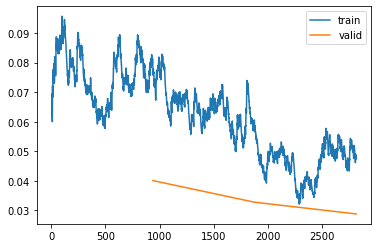

In [16]:
learn.recorder.plot_loss()

Save the model, trained in fastai
By default it is saved in the /models folder with .pth extension

In [16]:
learn.save('./fastai_cnn_NewNet_99')

Path('models/fastai_cnn_NewNet_99.pth')

Load the model(fastai) and save it as torch model for foolbox compatibility

In [17]:
model_new = learn.load('fastai_cnn_NewNet_99')
torch.save(model_new.model.state_dict(), 'fastai_cnn_NewNet_99_weights.pth')

Load model for the attack

In [18]:
# load the NewNet model
MyModel = NewNet()
MyModel.load_state_dict(torch.load('fastai_cnn_NewNet_weights.pth'))
MyModel.eval()

# load the CNet model
#MyModel_1 = CNet()
#MyModel_1.load_state_dict(torch.load('fastai_cnn_weights.pth'))
#MyModel_1.eval()

NewNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (drop): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

Create a Pytorch model for foolbox attack

In [19]:
preprocess = dict(mean=0.1307, std=0.3081)
bound = (0, 1)
fmodel_1 = fb.PyTorchModel(MyModel, bounds=bound, preprocessing=preprocess)

In [10]:
#fmodel_2 = fb.PyTorchModel(MyModel_1, bounds=bound, preprocessing=preprocess)

Three different attacks with 100 values of epsilons

In [20]:
attack0 = fb.attacks.LinfPGD()
attack1 = fb.attacks.BoundaryAttack()
attack2 = fb.attacks.FGSM()
attack = [attack0, attack1, attack2]
epsilon = np.linspace(0.0, 1, num=100)

Take model 1: Boundary attack with different batchsize

Black-Box attack: Boundary attack

In [21]:
image, label = ep.astensors(*samples(fmodel_1, dataset='mnist', batchsize=1024))

/home/venkat31/.conda/envs/n2gem/lib/python3.8/site-packages/foolbox/utils.py:80: UserWarning: samples() has only 20 samples and repeats itself if batchsize > 20
  warnings.warn(


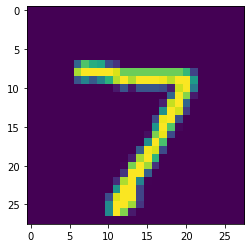

In [54]:
z = image.raw.view(1024,-1,28)
plt.imshow(z[0,:,:].cpu().numpy())

Save the real images to file: real_images.pt

In [55]:
torch.save(image.raw.view(image.shape[0], -1), "real_images.pt")

## Attack the model with Boundary attack

In [27]:
raw_adv, clip_adv, adv_ = attack1(fmodel_1, image, label, epsilons=epsilon)

In [33]:
torch_arr = []
for i in range(len(clip_adv)):
    torch_arr.append(clip_adv[i].raw.view(clip_adv[i].shape[0], -1))
torch_arr = np.array(torch_arr)
np.save("adv_samples_new.npy", torch_arr)

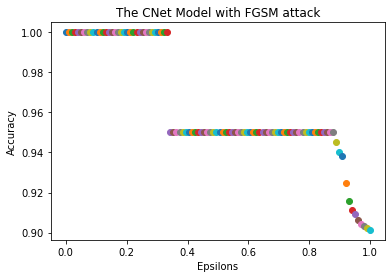

In [90]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for i in range(100):
    robust_accuracy = 1 - adv_[i, :].raw.cpu().numpy().astype(np.float32).mean(axis=-1)
    ax.scatter(epsilon[i], robust_accuracy)
    ax.set_xlabel("Epsilons")
    ax.set_ylabel("Accuracy")
    ax.set_title("The CNet Model with FGSM attack")
    #ax.legend()


Plot the results:

In [115]:
#import matplotlib.pyplot as plt
#fig, ax = plt.subplots()
#for success, labels in zip(succes_rates_1, batches):
#    robust_accuracy = 1 - success.cpu().numpy().astype(np.float32).mean(axis=-1)
#    ax.plot(epsilon, robust_accuracy, label=labels)
#    ax.set_xlabel("Epsilons")
#    ax.set_ylabel("Accuracy")
#    ax.set_title("The CNet Model with FGSM attack")
#    ax.legend()
#plt.savefig("CNet_FGSM_attack.png")

In [29]:
succes_rates_1 = []
succes_rates_2 = []

for attacking in attack:
    raw, clipped, is_adv_1 = attacking(fmodel_1, images_1, labels_1, epsilons=epsilon)
    raw1, clipped1, is_adv_2 = attacking(fmodel_2, images_2, labels_2, epsilons=epsilon)
    succes_rates_1.append(is_adv_1)
    succes_rates_2.append(is_adv_2)


In [116]:
#import matplotlib.pyplot as plt
#fig, ax = plt.subplots()
#label = ['LinfPGD', 'Boundary_Attack', 'FGSM']
#for success, labels in zip(succes_rates_1, label):
#    robust_accuracy = 1 - success.cpu().numpy().astype(np.float32).mean(axis=-1)
#    ax.plot(epsilon, robust_accuracy, label=labels)
#    ax.set_xlabel("Epsilons")
#    ax.set_ylabel("Accuracy")
#    ax.set_title("The NewNet Model")
#    ax.legend()   

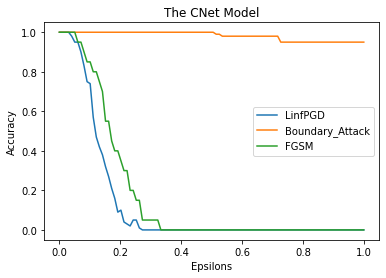

In [31]:
for success, labels in zip(succes_rates_2, label):
    robust_accuracy = 1 - success.cpu().numpy().astype(np.float32).mean(axis=-1)
    plt.plot(epsilon, robust_accuracy, label=labels)
    plt.xlabel("Epsilons")
    plt.ylabel("Accuracy")
    plt.title("The CNet Model")
    plt.legend()   
plt.show()

## Analysis on NewNet model after attack
- adv_samples.npy - the adversarial samples for epsilons ranging from 0 - 1 , 100 values
- real_images.pt - the real images as torch tensors

In [56]:
gen = np.load("adv_samples_new.npy", allow_pickle=True)
real = torch.load("real_images.pt", map_location='cpu')

Plot a real & adversarial sample

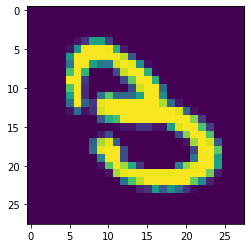

In [109]:
plt.imshow(real.numpy().reshape(real.shape[0], 28, 28)[798,:,:])

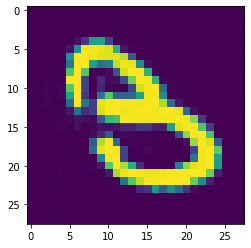

In [111]:
plt.imshow(gen[34].cpu().numpy().reshape(real.shape[0], 28, 28)[798,:,:])

In [114]:
#np.where(adv_.raw.cpu().numpy()[65, :]==True)[0]
print(adv_[34, 798])
print("epsilon value: ",epsilon[34])

PyTorchTensor(tensor(True, device='cuda:0'))
epsilon value:  0.3434343434343435


- Check the density & coverage between the adv samples and real samples

In [57]:
from n2gem import metrics

In [58]:
den = []
for i in range(3):
    density_value = metrics.gem_build_density(real, real.shape[0], gen[i].cpu(), 'indexflatl2', nk=3)
    den.append(density_value)
#coverage_value = metrics.gem_build_coverage(real, real.shape[0], gen[i].cpu(), 'indexflatl2', nk=3)
print(den)

The tree is created on the dataset of shape torch.Size([1024, 784]) using cuda
Creating the tree by indexflatl2 took 0.00125 sec
The tree is created on the dataset of shape torch.Size([1024, 784]) using cuda
Creating the tree by indexflatl2 took 0.00124 sec
The tree is created on the dataset of shape torch.Size([1024, 784]) using cuda
Creating the tree by indexflatl2 took 0.00130 sec
[tensor(5.1136), tensor(0.5413), tensor(0.)]


In [59]:
from sklearn.manifold import TSNE

In [60]:
x1 = real.cpu().numpy()
x2 = gen[0].cpu().numpy()

In [65]:
x1 = (x1 - np.min(x1))/(np.max(x1) - np.min(x1))

In [66]:
real_x = TSNE(n_components=2).fit_transform(x1)
gen_x = TSNE(n_components=2).fit_transform(x2)